# Attempt 2

In [2631]:
import math
import time
import torch
import gpytorch
import numpy as np
import random as rnd

from matplotlib import pyplot as plt

# randomizes the datapoint inputs every run
np.random.seed(2) 
# np.random.seed(rnd.randint(0, 1000000)) # deactivated the randomizer for simplicity during testing

# timer module to calculate run time
time_start = time.time() 

# Stage 0: Setting up HF and LF data sets

In [2632]:
# Training data is 1000 points in [0,1] inclusive regularly spaced
X = torch.linspace(0, 1, 1000)

# defines the HF and LF sine functions. Gaussian noise was excluded for simplicity during testing
def hf(x): 
    return 1.8*torch.sin(x * (8 * math.pi))*2*x # + torch.randn(x.size()) * math.sqrt(0.04) #* the accurately simulated sin model for HF data

def lf(x):
    return torch.sin(x * (8 * math.pi))*x # + torch.randn(x.size()) * math.sqrt(0.04) #* the inaccurately simulated sin model for LF data

# Setting the number of LF and HF points
Nlf=20
Nhf=8

#Sampling LF and HF model randomly
X_lf = np.random.permutation(X)[0:Nlf] # basically randomly aranges the 50 different values in X array, from 0 to "len(Nlf)"
X_hf = np.random.permutation(X_lf)[0:Nhf]

# Converting np.ndarray to tensor to be able to utilize GPyTorch
X_lf = torch.from_numpy(X_lf)
X_hf = torch.from_numpy(X_hf) 

# Stage 1: HF Modelling using Exact Gaussian Process Model
Step 1: Setting up the HF data

In [2633]:
#Labeling train_x and train_y data
train_x = X_hf # Randomly arranged HF points
train_y = hf(X_hf) # HF points ran through HF sine function (accurate sine function)


print(train_x.size())
print(train_y.size())

torch.Size([8])
torch.Size([8])


Step 2: Setting up the HF Model

In [2634]:
# Simplest form of Gaussian processs model, Exact intereference
class ExactGPModel(gpytorch.models.ExactGP): # gpytorch.models.ExactGP is the simplest GP Model.
    def __init__(self, train_x, train_y, likelihood): 
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood) # Adds the training sets and likelihood to the GP model
        self.mean_module = gpytorch.means.ConstantMean() #  A Mean - This defines the prior mean of the GP.
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # A Kernel - This defines the prior covariance of the GP-
        # a method of using a linear classifier to solve a non-linear problem.

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # This is the object used to represent multivariate normal distributions.
        # multivariate Gaussian distribution, or joint normal distribution is a generalization of the one-dimensional normal distribution to higher dimensions. 

Step 3: Initializing the model and likelihood and smoke testing

In [2635]:
# set a number of training iterations for both models 
training_iter = 300

# initialize likelihood and model 
likelihood = gpytorch.likelihoods.GaussianLikelihood() #? how likekly a model has a certain parameter value given some data
model = ExactGPModel(train_x, train_y, likelihood) # calling ExactGPModel from the class as "model"
# print(model)

# this is for running the notebook in our testing framework with an added smoke test 
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else training_iter

Step 4: Training the model

In [2636]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward() # Computes the gradient and stores them in the tensors once you call .backward() 
    
    # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.item(),
    #     model.likelihood.noise.item()
    # ))
    optimizer.step()

Step 5: Make predictions with the model

In [2637]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # turns off gradients computation
    test_x = X
    observed_pred = likelihood(model(test_x)) # output of LF model with the likelihoodand model
print(observed_pred)

MultivariateNormal(loc: torch.Size([1000]))


# Stage 2: LF Model Modelling using Exact Gaussian Process Model

In [2638]:
# Set the low fidelity data values

train_x2 = X_lf # Randomly arranged HF points
train_y2 = lf(X_lf)  # LF points ran through LF sine function (inaccurate sine function)

In [2639]:
# Simplest form of Gaussian processs model, Exact intereference
class ExactGPModel_LF(gpytorch.models.ExactGP): 
    def __init__(self, train_x2, train_y2, likelihood): 
        super(ExactGPModel, self).__init__(train_x2, train_y2, likelihood) 
        self.mean_module = gpytorch.means.ConstantMean() 
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [2640]:
# initialize likelihood and model 
likelihood = gpytorch.likelihoods.GaussianLikelihood() 
model_2 = ExactGPModel(train_x2, train_y2, likelihood) 

import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else training_iter

In [2641]:
# train the model and likelihood
model_2.train()
likelihood.train()

optimizer = torch.optim.Adam(model_2.parameters(), lr=0.1) 

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_2)

for i in range(training_iter):
    optimizer.zero_grad()

    output = model_2(train_x2)

    loss = -mll(output, train_y2)

    loss.backward()

    optimizer.step()

In [2642]:
model_2.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x2 = X
    observed_pred2 = likelihood(model_2(test_x2))

    observed_pred2_mean = observed_pred2.mean

# Stage 3: MF Modelling Stage 
Using LF model and HF points, predict an L1mean

In [2643]:
train_x3 = X_lf
train_y3 = lf(X_lf)

#--------------------------------------------------------------


class ExactGPModel(gpytorch.models.ExactGP): 
    def __init__(self, train_x3, train_3, likelihood): 
        super(ExactGPModel, self).__init__(train_x3, train_y3, likelihood) 
        self.mean_module = gpytorch.means.ConstantMean() 
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) 

        
#--------------------------------------------------------------

likelihood = gpytorch.likelihoods.GaussianLikelihood() 
model_3 = ExactGPModel(train_x3, train_y3, likelihood)

import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else training_iter


#--------------------------------------------------------------


model_3.train()
likelihood.train()

optimizer = torch.optim.Adam(model_3.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_3)

for i in range(training_iter):

    optimizer.zero_grad()

    output = model_3(train_x3)

    loss = -mll(output, train_y3)

    loss.backward() 

    optimizer.step()

model_3.eval()
likelihood.eval()

# HF points getting trained by LF model
with torch.no_grad(), gpytorch.settings.fast_pred_var(): 
    test_x3 = X_hf
    observed_pred3 = likelihood(model_3(test_x3)) 

observed_pred3_mean = observed_pred3.mean[:,np.newaxis]
X_hf = X_hf[:,np.newaxis]

# X_hf = X_hf.numpy()
# observed_pred3_mean = observed_pred3_mean.numpy()

L2_train = np.hstack((X_hf, observed_pred3_mean))



# Fix the X and observed_pred2_mean back to tensors
# X_hf = torch.tensor(X_hf)
# observed_pred3_mean = torch.tensor(observed_pred3_mean)


print((len(L2_train))) # HF points trained in LF model, stacked with HF points again

8


# MF Model


In [2644]:
train_x4 = torch.tensor(L2_train)[:,np.newaxis]
train_y4 = hf(X_hf)

#--------------------------------------------------------------


class ExactGPModel(gpytorch.models.ExactGP): 
    def __init__(self, train_x4, train_y4, likelihood): 
        super(ExactGPModel, self).__init__(train_x4, train_y4, likelihood) 
        self.mean_module = gpytorch.means.ConstantMean() 
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) 

        
#--------------------------------------------------------------

training_iter = 300

likelihood = gpytorch.likelihoods.GaussianLikelihood() 
model_4 = ExactGPModel(train_x4, train_y4, likelihood)

import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else training_iter


#--------------------------------------------------------------


model_4.train()
likelihood.train()

optimizer = torch.optim.Adam(model_4.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_4)

for i in range(training_iter):

    optimizer.zero_grad()

    output = model_4(train_x4)

    loss = -mll(output, train_y4)

    loss.sum().backward()
    # loss.backward(torch.Tensor([1, 1]))

    optimizer.step()

model_4.eval()
likelihood.eval()


X = X.numpy()
X = X[:,np.newaxis]


observed_pred2_mean = observed_pred2_mean.numpy()
observed_pred2_mean = observed_pred2_mean[:,np.newaxis]


L2_test = np.hstack((X, observed_pred2_mean))


print(len(L2_test))

# HF points getting trained by LF model
with torch.no_grad(), gpytorch.settings.fast_pred_var(): 
    test_x4 = torch.tensor(L2_test)

    observed_pred4 = likelihood(model_4(test_x4)) 

observed_pred4_mean = observed_pred4.mean



# reshape the pred4_mean to plot
observed_pred4_mean = torch.flip(observed_pred4_mean, [0,1])
observed_pred4_mean = observed_pred4_mean.reshape(-1,1)
print((observed_pred4_mean.size()))
observed_pred4_mean = torch.squeeze(observed_pred4_mean, 1000)
print((observed_pred4_mean.size()))



# Fix the X and observed_pred2_mean back to tensors
X = torch.tensor(X)
observed_pred2_mean = torch.tensor(observed_pred2_mean)

1000


RuntimeError: Flattening the training labels failed. The most common cause of this error is that the shapes of the prior mean and the training labels are mismatched. The shape of the train targets is torch.Size([20]), while the reported shape of the mean is torch.Size([8, 1]).

In [ ]:


# reshape the pred4_mean to plot
observed_pred4_mean = torch.flip(observed_pred4_mean, [0,1])
observed_pred4_mean = observed_pred4_mean.reshape(-1,1)
print((observed_pred4_mean.size()))

observed_pred4_mean = observed_pred4_mean[0:1000,:]
print((observed_pred4_mean.size()))



# Fix the X and observed_pred2_mean back to tensors
X = torch.tensor(X)
observed_pred2_mean = torch.tensor(observed_pred2_mean)

torch.Size([8000, 1])
torch.Size([1000, 1])


# Stage 4: Plotting

Finished in 25.311197519302368 seconds.


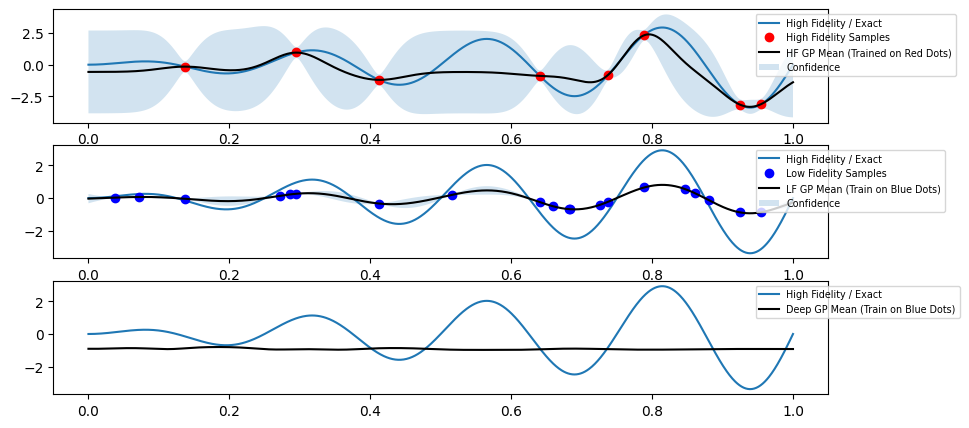

In [ ]:
with torch.no_grad():
    f, ax = plt.subplots(3, figsize = (10, 5))

    # Get upper and lower confidence bounds
    lower,  upper  =  observed_pred.confidence_region()
    lower2, upper2 = observed_pred2.confidence_region()
    lower3, upper3 = observed_pred3.confidence_region()
    lower4, upper4 = observed_pred4.confidence_region()
    
    #High Fidelity / Exact Line
    ax[0].plot(X,hf(X), label="High Fidelity / Exact")
    ax[1].plot(X,hf(X), label="High Fidelity / Exact")
    ax[2].plot(X,hf(X), label="High Fidelity / Exact")

    # Sample Points
    ax[0].plot(train_x.numpy(),train_y.numpy(), 'ro',label="High Fidelity Samples")
    ax[1].plot(train_x2.numpy(),train_y2.numpy(), 'bo', label="Low Fidelity Samples")
   
    # GP Mean PREDICTIONS
    ax[0].plot(test_x.numpy(),observed_pred.mean.numpy(), 'k', label = "HF GP Mean (Trained on Red Dots)")
    ax[1].plot(test_x2.numpy(),observed_pred2.mean.numpy(), 'k', label = "LF GP Mean (Train on Blue Dots)")
    ax[2].plot(X.numpy(),observed_pred4_mean.numpy(), 'k', label = "Deep GP Mean (Train on Blue Dots)")
    
    # Shade between the lower and upper confidence bounds
    ax[0].fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.2, label = "Confidence")
    ax[1].fill_between(test_x2.numpy(), lower2.numpy(), upper2.numpy(), alpha=0.2, label = "Confidence") 
   
    #Legends
    ax[2].legend(bbox_to_anchor=(0.9, 1), loc='upper left', fontsize='x-small')
    ax[1].legend(bbox_to_anchor=(0.9, 1), loc='upper left', fontsize='x-small')
    ax[0].legend(bbox_to_anchor=(0.9, 1), loc='upper left', fontsize='x-small')

abs_path = os.path.abspath('')
dir = os.path.dirname(abs_path)

plt.savefig(abs_path + "\\attempt_2_plot.pdf")
print(f"Finished in {(time.time() - time_start)} seconds." )